<a href="https://colab.research.google.com/github/OverfitSurvivor/code/blob/main/drone_DAE_1__%EC%88%98%EC%A0%95_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile

zip_path = "/content/drive/MyDrive/ICSV31AIChallengeDataset.zip"  # 업로드한 ZIP 파일 경로
extract_path = "/content/ICSV31AIChallengeDataset"  # 압축을 풀 폴더 경로

# 폴더가 없으면 생성
os.makedirs(extract_path, exist_ok=True)

# 압축 해제
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료:", extract_path)

압축 해제 완료: /content/ICSV31AIChallengeDataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 모듈 불러오기

In [ ]:
import csv
import argparse
import os
from typing import Any, List, Tuple

import torch
import torchaudio
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

## 라벨링 및 데이터셋 로더
+ global scaling STFT 적용

In [ ]:
#######################
# 1. Utils
#######################
def read_csv(file_path: str) -> List:
    with open(file_path, "r") as f:
        reader = csv.reader(f)
        return list(reader)

def save_csv(save_data: List[Any], save_file_path: str) -> None:
    with open(save_file_path, "w", newline="") as f:
        writer = csv.writer(f, lineterminator="\n")
        writer.writerows(save_data)

def get_anomaly_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    train_mode = file_name.split("_")[0]
    if train_mode == "test":
        return -1
    elif "normal" in file_name:
        return 0
    else:
        return 1

def get_drone_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    drone_mode = file_name.split("_")[1]
    if drone_mode == "A":
        return 0
    elif drone_mode == "B":
        return 1
    elif drone_mode == "C":
        return 2
    else:
        return -1

def get_direction_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    direction_mode = file_name.split("_")[2]
    if direction_mode == "Back":
        return 0
    elif direction_mode == "Front":
        return 1
    elif direction_mode == "Left":
        return 2
    elif direction_mode == "Right":
        return 3
    elif direction_mode == "Clockwise":
        return 4
    elif direction_mode == "CounterClockwise":
        return 5
    else:
        return -1

#######################
# 2. Feature Extraction & Augmentation
#######################
# 계산된 전역 평균과 표준편차
GLOBAL_MEAN = -6.191
GLOBAL_STD = 12.042

def wav_to_log_stft(
    wav_path: str,
    sr: int,
    n_fft: int,
    win_length: int,
    hop_length: int,
    power: float,
) -> torch.Tensor:
    """
    WAV 파일을 STFT 기반 로그 스펙트럼으로 변환.
    - torchaudio.transforms.Spectrogram로 STFT 계산
    - AmplitudeToDB로 로그 변환 후 global standard scaling 적용 **
    """
    stft_transform = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=power
    )
    wav_data, _ = torchaudio.load(wav_path)
    spec = stft_transform(wav_data)
    amp_to_db = torchaudio.transforms.AmplitudeToDB()
    log_spec = amp_to_db(spec)

    # 전체 데이터셋의 평균과 표준편차로 정규화 적용
    log_spec = (log_spec - GLOBAL_MEAN) / (GLOBAL_STD + 1e-9)
    return log_spec


def augment_spec(spec: torch.Tensor) -> torch.Tensor:
    max_shift = int(spec.shape[-1] * 0.1)
    shift = torch.randint(-max_shift, max_shift + 1, (1,)).item()
    spec = torch.roll(spec, shifts=shift, dims=-1)
    time_mask_param = max(1, int(spec.shape[-1] * 0.1))
    time_mask = torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param)
    spec = time_mask(spec)
    freq_mask_param = max(1, int(spec.shape[-2] * 0.1))
    freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param)
    spec = freq_mask(spec)
    return spec

#######################
# 3. Dataset
#######################
class BaselineDataLoader(Dataset):
    def __init__(
        self,
        file_list: List[str],
        sr: int,
        n_fft: int,
        win_length: int,
        hop_length: int,
        power: float,
        augment: bool = False
    ) -> None:
        self.file_list = file_list
        self.sr = sr
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.power = power
        self.augment = augment

    def __len__(self) -> int:
        return len(self.file_list)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, int, int]:
        wav_path = self.file_list[idx]
        spec = wav_to_log_stft(wav_path, self.sr, self.n_fft, self.win_length, self.hop_length, self.power)
        if self.augment:
            spec = augment_spec(spec)
        anomaly_label = get_anomaly_label(wav_path)
        drone_label = get_drone_label(wav_path)
        direction_label = get_direction_label(wav_path)
        return spec, anomaly_label, drone_label, direction_label

def get_train_loader(args: argparse.Namespace, pin_memory: bool = False, num_workers: int = 0) -> DataLoader:
    file_list = sorted(os.listdir(args.train_dir))
    file_list = [os.path.join(args.train_dir, f) for f in file_list if get_anomaly_label(f) == 0]
    dataset = BaselineDataLoader(
        file_list,
        sr=args.sr,
        n_fft=args.n_fft,
        win_length=args.win_length,
        hop_length=args.hop_length,
        power=args.power,
        augment=True
    )
    return DataLoader(dataset, batch_size=args.batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory,
                      persistent_workers=True, prefetch_factor=2)

def get_eval_loader(args: argparse.Namespace, pin_memory: bool = False, num_workers: int = 0) -> Tuple[DataLoader, List[str]]:
    file_list = sorted(os.listdir(args.eval_dir))
    file_list = [os.path.join(args.eval_dir, f) for f in file_list]
    dataset = BaselineDataLoader(
        file_list,
        sr=args.sr,
        n_fft=args.n_fft,
        win_length=args.win_length,
        hop_length=args.hop_length,
        power=args.power,
        augment=False
    )
    return DataLoader(dataset, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory,
                      persistent_workers=True, prefetch_factor=2), file_list

## 모델 학습 및 평가

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse, os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics

#######################
# Utility: 크기 맞춤 함수
#######################
def match_size(source: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    src_h, src_w = source.size(2), source.size(3)
    tgt_h, tgt_w = target.size(2), target.size(3)
    # source가 target보다 크면 center crop
    if src_h > tgt_h or src_w > tgt_w:
        start_h = (src_h - tgt_h) // 2
        start_w = (src_w - tgt_w) // 2
        source = source[:, :, start_h:start_h+tgt_h, start_w:start_w+tgt_w]
    # source가 target보다 작으면 pad
    elif src_h < tgt_h or src_w < tgt_w:
        diff_h = tgt_h - src_h
        diff_w = tgt_w - src_w
        source = F.pad(source, (diff_w // 2, diff_w - diff_w // 2,
                                diff_h // 2, diff_h - diff_h // 2))
    return source

#######################
# Model Architecture with Residual Blocks & Dropout (DAE)
#######################
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.05):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # Downsample if input/output 채널 또는 stride가 맞지 않을 경우
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = nn.Identity()

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.05):
        super(EncoderBlock, self).__init__()
        self.resblock = ResidualBlock(in_channels, out_channels, stride=2, dropout=dropout)
    def forward(self, x):
        return self.resblock(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.05):
        super(DecoderBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3,
                                         stride=2, padding=1, output_padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        # Concat 후 채널 수가 2배가 되므로 이를 반영하여 ResidualBlock 구성
        self.resblock = ResidualBlock(out_channels * 2, out_channels, stride=1, dropout=dropout)

    def forward(self, x, skip):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        skip = match_size(skip, x)
        x = torch.cat([x, skip], dim=1)  # skip connection
        x = self.resblock(x)   #residual block
        return x

class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_channels=1, dropout=0.05):
        super(DenoisingAutoencoder, self).__init__()
        self.enc1 = EncoderBlock(input_channels, 32, dropout)
        self.enc2 = EncoderBlock(32, 64, dropout)
        self.enc3 = EncoderBlock(64, 128, dropout)
        self.enc4 = EncoderBlock(128, 256, dropout)
        self.enc5 = EncoderBlock(256, 512, dropout)
        self.dec5 = DecoderBlock(512, 256, dropout)
        self.dec4 = DecoderBlock(256, 128, dropout)
        self.dec3 = DecoderBlock(128, 64, dropout)
        self.dec2 = DecoderBlock(64, 32, dropout)
        self.dec1 = nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2,
                                       padding=1, output_padding=1)
    def forward(self, x):
        e1 = self.enc1(x)  # (B, 32, H/2, W/2)
        e2 = self.enc2(e1)  # (B, 64, H/4, W/4)
        e3 = self.enc3(e2)  # (B, 128, H/8, W/8)
        e4 = self.enc4(e3)  # (B, 256, H/16, W/16)
        e5 = self.enc5(e4)  # (B, 512, H/32, W/32)
        d5 = self.dec5(e5, e4)
        d4 = self.dec4(d5, e3)
        d3 = self.dec3(d4, e2)
        d2 = self.dec2(d3, e1)
        d1 = self.dec1(d2)
        d1 = F.interpolate(d1, size=x.shape[2:], mode="bilinear", align_corners=False)
        return d1

def DAEModel(dropout) -> nn.Module:
    return DenoisingAutoencoder(input_channels=1, dropout=dropout)

#######################
# 5. Train & Evaluate
#######################
def get_args() -> argparse.Namespace:
    param = {
        "train_dir": "/content/ICSV31AIChallengeDataset/train",
        "eval_dir": "/content/ICSV31AIChallengeDataset/eval",
        "result_dir": "/content/drive/MyDrive",
        "model_dir": "/content/drive/MyDrive",
        "model_path": "model_dae_b.pth",
        "epochs": 150,
        "batch_size": 32,
        "lr": 0.001,
        "gpu": 0,
        "n_workers": 1,
        "sr": 16000,
        "n_fft": 2048,
        "win_length": 512,
        "hop_length": 512,
        "power": 2.0,
        "early_stopping_patience": 10,
        "min_lr": 1e-6,
        "noise_factor": 0.2,
        "dropout": 0.05
    }
    parser = argparse.ArgumentParser()
    parser.add_argument("--train-dir", default=param["train_dir"], type=str)
    parser.add_argument("--eval-dir", default=param["eval_dir"], type=str)
    parser.add_argument("--result-dir", default=param["result_dir"], type=str)
    parser.add_argument("--model-dir", default=param["model_dir"], type=str)
    parser.add_argument("--model-path", default=param["model_path"], type=str)
    parser.add_argument("--epochs", default=param["epochs"], type=int)
    parser.add_argument("--batch-size", default=param["batch_size"], type=int)
    parser.add_argument("--lr", default=param["lr"], type=float)
    parser.add_argument("--gpu", default=param["gpu"], type=int)
    parser.add_argument("--n-workers", default=param["n_workers"], type=int)
    parser.add_argument("--sr", default=param["sr"], type=int)
    parser.add_argument("--n-fft", default=param["n_fft"], type=int)
    parser.add_argument("--win-length", default=param["win_length"], type=int)
    parser.add_argument("--hop-length", default=param["hop_length"], type=int)
    parser.add_argument("--power", default=param["power"], type=float)
    parser.add_argument("--early-stopping-patience", default=param["early_stopping_patience"], type=int)
    parser.add_argument("--min-lr", default=param["min_lr"], type=float)
    parser.add_argument("--noise-factor", default=param["noise_factor"], type=float)
    parser.add_argument("--dropout", default=param["dropout"], type=float)
    args, unknown = parser.parse_known_args()
    return args

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def train_and_evaluate(args: argparse.Namespace) -> None:
    print("Training started...")
    os.makedirs(args.result_dir, exist_ok=True)
    os.makedirs(args.model_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # GPU 최적화를 위한 cudnn benchmark 활성화
    if device.type == "cuda":
        torch.backends.cudnn.benchmark = True

    model = DAEModel(dropout=args.dropout).to(device)

    # Model summary 출력 (옵션)
    try:
        from torchsummary import summary
        summary(model, input_size=(1, 256, 256))
    except ImportError:
        print(model)

    # DataLoader에서 pin_memory 및 num_workers 옵션 적용 (get_train_loader 구현 필요)
    train_loader = get_train_loader(args, pin_memory=True, num_workers=args.n_workers)

    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs, eta_min=args.min_lr)
    criterion = nn.MSELoss()

    best_loss = float('inf')
    epochs_no_improve = 0
    epoch_losses = []

    # Automatic Mixed Precision (AMP) 적용을 위한 GradScaler 초기화
    scaler = torch.amp.GradScaler(device='cuda')

    for epoch in range(args.epochs):
        model.train()
        total_loss = 0.0
        count = 0
        p_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{args.epochs}", ncols=100)
        for data in p_bar:
            spec = data[0].to(device)
            noisy_spec = spec + args.noise_factor * torch.randn_like(spec)
            optimizer.zero_grad()

            # AMP 적용: autocast 내에서 forward 및 loss 계산
            with torch.amp.autocast('cuda'):
                decoded = model(noisy_spec)
                loss = criterion(decoded, spec)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            count += 1
            p_bar.set_description(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

        avg_loss = total_loss / count
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")
        scheduler.step()

        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), os.path.join(args.model_dir, args.model_path))
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= args.early_stopping_patience:
                print("Early stopping triggered.")
                break

    print("Training completed.")
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss per Epoch (DAE)")
    plt.grid(True)
    plt.show()

    print("Evaluation started...")
    model.load_state_dict(torch.load(os.path.join(args.model_dir, args.model_path), map_location=device))
    model.eval()
    eval_loader, file_list = get_eval_loader(args, pin_memory=True, num_workers=args.n_workers)
    y_true, y_pred = [], []
    for idx, data in enumerate(eval_loader):
        spec = data[0].to(device)
        anomaly_label = data[1]
        with torch.no_grad():
            decoded = model(spec)
        loss = criterion(decoded, spec)
        y_true.append(1 if anomaly_label.item() > 0 else 0)
        y_pred.append(loss.item())

    pr_auc = metrics.average_precision_score(y_true, y_pred)
    print("Evaluation PR AUC:", pr_auc)

Training started...
Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]              64
       BatchNorm2d-2         [-1, 32, 128, 128]              64
            Conv2d-3         [-1, 32, 128, 128]             320
       BatchNorm2d-4         [-1, 32, 128, 128]              64
         LeakyReLU-5         [-1, 32, 128, 128]               0
           Dropout-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]           9,248
       BatchNorm2d-8         [-1, 32, 128, 128]              64
         LeakyReLU-9         [-1, 32, 128, 128]               0
    ResidualBlock-10         [-1, 32, 128, 128]               0
     EncoderBlock-11         [-1, 32, 128, 128]               0
           Conv2d-12           [-1, 64, 64, 64]           2,112
      BatchNorm2d-13           [-1, 64, 64, 64]             128


Epoch 1, Loss: 0.2095: 100%|██████████████████████████████████████| 169/169 [00:25<00:00,  6.65it/s]


Epoch 1 average loss: 0.2774


Epoch 2, Loss: 0.1691: 100%|██████████████████████████████████████| 169/169 [00:21<00:00,  7.87it/s]


Epoch 2 average loss: 0.1919


Epoch 3, Loss: 0.1552: 100%|██████████████████████████████████████| 169/169 [00:21<00:00,  7.69it/s]


Epoch 3 average loss: 0.1538


Epoch 4, Loss: 0.1218: 100%|██████████████████████████████████████| 169/169 [00:21<00:00,  7.95it/s]


Epoch 4 average loss: 0.1282


Epoch 5, Loss: 0.1236: 100%|██████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 5 average loss: 0.1100


Epoch 6, Loss: 0.0947: 100%|██████████████████████████████████████| 169/169 [00:21<00:00,  7.93it/s]


Epoch 6 average loss: 0.1008


Epoch 7, Loss: 0.0967: 100%|██████████████████████████████████████| 169/169 [00:21<00:00,  7.81it/s]


Epoch 7 average loss: 0.0934


Epoch 8, Loss: 0.0853: 100%|██████████████████████████████████████| 169/169 [00:22<00:00,  7.38it/s]


Epoch 8 average loss: 0.0891


Epoch 9, Loss: 0.0894: 100%|██████████████████████████████████████| 169/169 [00:22<00:00,  7.44it/s]


Epoch 9 average loss: 0.0869


Epoch 10, Loss: 0.0810: 100%|█████████████████████████████████████| 169/169 [00:22<00:00,  7.46it/s]


Epoch 10 average loss: 0.0826


Epoch 11, Loss: 0.0717: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  7.99it/s]


Epoch 11 average loss: 0.0786


Epoch 12, Loss: 0.0807: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 12 average loss: 0.0773


Epoch 13, Loss: 0.0778: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  7.95it/s]


Epoch 13 average loss: 0.0746


Epoch 14, Loss: 0.0697: 100%|█████████████████████████████████████| 169/169 [00:22<00:00,  7.41it/s]


Epoch 14 average loss: 0.0725


Epoch 15, Loss: 0.0718: 100%|█████████████████████████████████████| 169/169 [00:22<00:00,  7.43it/s]


Epoch 15 average loss: 0.0704


Epoch 16, Loss: 0.0710: 100%|█████████████████████████████████████| 169/169 [00:22<00:00,  7.49it/s]


Epoch 16 average loss: 0.0693


Epoch 17, Loss: 0.0668: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 17 average loss: 0.0676


Epoch 18, Loss: 0.0681: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 18 average loss: 0.0661


Epoch 19, Loss: 0.0641: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 19 average loss: 0.0644


Epoch 20, Loss: 0.0613: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 20 average loss: 0.0625


Epoch 21, Loss: 0.0611: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 21 average loss: 0.0618


Epoch 22, Loss: 0.0573: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 22 average loss: 0.0604


Epoch 23, Loss: 0.0587: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 23 average loss: 0.0593


Epoch 24, Loss: 0.0668: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 24 average loss: 0.0584


Epoch 25, Loss: 0.0533: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 25 average loss: 0.0569


Epoch 26, Loss: 0.0609: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 26 average loss: 0.0563


Epoch 27, Loss: 0.0538: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 27 average loss: 0.0557


Epoch 28, Loss: 0.0561: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 28 average loss: 0.0549


Epoch 29, Loss: 0.0550: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 29 average loss: 0.0535


Epoch 30, Loss: 0.0555: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  7.99it/s]


Epoch 30 average loss: 0.0525


Epoch 31, Loss: 0.0511: 100%|█████████████████████████████████████| 169/169 [00:23<00:00,  7.30it/s]


Epoch 31 average loss: 0.0522


Epoch 32, Loss: 0.0467: 100%|█████████████████████████████████████| 169/169 [00:22<00:00,  7.47it/s]


Epoch 32 average loss: 0.0510


Epoch 33, Loss: 0.0528: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  7.97it/s]


Epoch 33 average loss: 0.0507


Epoch 34, Loss: 0.0525: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 34 average loss: 0.0500


Epoch 35, Loss: 0.0540: 100%|█████████████████████████████████████| 169/169 [00:22<00:00,  7.54it/s]


Epoch 35 average loss: 0.0491


Epoch 36, Loss: 0.0474: 100%|█████████████████████████████████████| 169/169 [00:22<00:00,  7.44it/s]


Epoch 36 average loss: 0.0486


Epoch 37, Loss: 0.0505: 100%|█████████████████████████████████████| 169/169 [00:22<00:00,  7.49it/s]


Epoch 37 average loss: 0.0480


Epoch 38, Loss: 0.0415: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  7.83it/s]


Epoch 38 average loss: 0.0466


Epoch 39, Loss: 0.0470: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  7.77it/s]


Epoch 39 average loss: 0.0469


Epoch 40, Loss: 0.0525: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 40 average loss: 0.0460


Epoch 41, Loss: 0.0422: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  7.99it/s]


Epoch 41 average loss: 0.0445


Epoch 42, Loss: 0.0446: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  7.98it/s]


Epoch 42 average loss: 0.0450


Epoch 43, Loss: 0.0484: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 43 average loss: 0.0436


Epoch 44, Loss: 0.0461: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 44 average loss: 0.0446


Epoch 45, Loss: 0.0456: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 45 average loss: 0.0432


Epoch 46, Loss: 0.0410: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 46 average loss: 0.0428


Epoch 47, Loss: 0.0409: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 47 average loss: 0.0418


Epoch 48, Loss: 0.0445: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 48 average loss: 0.0419


Epoch 49, Loss: 0.0391: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 49 average loss: 0.0418


Epoch 50, Loss: 0.0401: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 50 average loss: 0.0409


Epoch 51, Loss: 0.0390: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 51 average loss: 0.0407


Epoch 52, Loss: 0.0408: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 52 average loss: 0.0394


Epoch 53, Loss: 0.0502: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 53 average loss: 0.0400


Epoch 54, Loss: 0.0375: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 54 average loss: 0.0398


Epoch 55, Loss: 0.0394: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 55 average loss: 0.0392


Epoch 56, Loss: 0.0400: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 56 average loss: 0.0389


Epoch 57, Loss: 0.0350: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 57 average loss: 0.0380


Epoch 58, Loss: 0.0391: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 58 average loss: 0.0384


Epoch 59, Loss: 0.0380: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 59 average loss: 0.0384


Epoch 60, Loss: 0.0401: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 60 average loss: 0.0375


Epoch 61, Loss: 0.0368: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 61 average loss: 0.0372


Epoch 62, Loss: 0.0358: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 62 average loss: 0.0365


Epoch 63, Loss: 0.0372: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 63 average loss: 0.0365


Epoch 64, Loss: 0.0371: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 64 average loss: 0.0366


Epoch 65, Loss: 0.0366: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 65 average loss: 0.0365


Epoch 66, Loss: 0.0335: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 66 average loss: 0.0360


Epoch 67, Loss: 0.0343: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 67 average loss: 0.0356


Epoch 68, Loss: 0.0337: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 68 average loss: 0.0354


Epoch 69, Loss: 0.0352: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 69 average loss: 0.0347


Epoch 70, Loss: 0.0400: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 70 average loss: 0.0350


Epoch 71, Loss: 0.0336: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 71 average loss: 0.0348


Epoch 72, Loss: 0.0335: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  7.98it/s]


Epoch 72 average loss: 0.0345


Epoch 73, Loss: 0.0336: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 73 average loss: 0.0336


Epoch 74, Loss: 0.0320: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 74 average loss: 0.0335


Epoch 75, Loss: 0.0331: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 75 average loss: 0.0334


Epoch 76, Loss: 0.0315: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 76 average loss: 0.0329


Epoch 77, Loss: 0.0335: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 77 average loss: 0.0324


Epoch 78, Loss: 0.0315: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 78 average loss: 0.0324


Epoch 79, Loss: 0.0313: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 79 average loss: 0.0325


Epoch 80, Loss: 0.0325: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 80 average loss: 0.0322


Epoch 81, Loss: 0.0320: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 81 average loss: 0.0323


Epoch 82, Loss: 0.0375: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 82 average loss: 0.0317


Epoch 83, Loss: 0.0311: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 83 average loss: 0.0318


Epoch 84, Loss: 0.0324: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 84 average loss: 0.0316


Epoch 85, Loss: 0.0310: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  7.91it/s]


Epoch 85 average loss: 0.0312


Epoch 86, Loss: 0.0299: 100%|█████████████████████████████████████| 169/169 [00:22<00:00,  7.65it/s]


Epoch 86 average loss: 0.0310


Epoch 87, Loss: 0.0326: 100%|█████████████████████████████████████| 169/169 [00:22<00:00,  7.49it/s]


Epoch 87 average loss: 0.0309


Epoch 88, Loss: 0.0311: 100%|█████████████████████████████████████| 169/169 [00:22<00:00,  7.47it/s]


Epoch 88 average loss: 0.0309


Epoch 89, Loss: 0.0300: 100%|█████████████████████████████████████| 169/169 [00:22<00:00,  7.48it/s]


Epoch 89 average loss: 0.0310


Epoch 90, Loss: 0.0299: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  7.93it/s]


Epoch 90 average loss: 0.0306


Epoch 91, Loss: 0.0295: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 91 average loss: 0.0303


Epoch 92, Loss: 0.0301: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 92 average loss: 0.0306


Epoch 93, Loss: 0.0301: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 93 average loss: 0.0302


Epoch 94, Loss: 0.0301: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 94 average loss: 0.0301


Epoch 95, Loss: 0.0296: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  7.99it/s]


Epoch 95 average loss: 0.0299


Epoch 96, Loss: 0.0315: 100%|█████████████████████████████████████| 169/169 [00:22<00:00,  7.42it/s]


Epoch 96 average loss: 0.0300


Epoch 97, Loss: 0.0282: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 97 average loss: 0.0298


Epoch 98, Loss: 0.0302: 100%|█████████████████████████████████████| 169/169 [00:21<00:00,  7.98it/s]


Epoch 98 average loss: 0.0298


Epoch 99, Loss: 0.0286: 100%|█████████████████████████████████████| 169/169 [00:22<00:00,  7.60it/s]


Epoch 99 average loss: 0.0294


Epoch 100, Loss: 0.0295: 100%|████████████████████████████████████| 169/169 [00:22<00:00,  7.41it/s]


Epoch 100 average loss: 0.0296


Epoch 101, Loss: 0.0302: 100%|████████████████████████████████████| 169/169 [00:22<00:00,  7.49it/s]


Epoch 101 average loss: 0.0295


Epoch 102, Loss: 0.0279: 100%|████████████████████████████████████| 169/169 [00:22<00:00,  7.54it/s]


Epoch 102 average loss: 0.0293


Epoch 103, Loss: 0.0287: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  7.99it/s]


Epoch 103 average loss: 0.0293


Epoch 104, Loss: 0.0278: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 104 average loss: 0.0291


Epoch 105, Loss: 0.0291: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 105 average loss: 0.0289


Epoch 106, Loss: 0.0291: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 106 average loss: 0.0288


Epoch 107, Loss: 0.0287: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  7.99it/s]


Epoch 107 average loss: 0.0287


Epoch 108, Loss: 0.0285: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 108 average loss: 0.0287


Epoch 109, Loss: 0.0292: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 109 average loss: 0.0285


Epoch 110, Loss: 0.0282: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 110 average loss: 0.0287


Epoch 111, Loss: 0.0285: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 111 average loss: 0.0285


Epoch 112, Loss: 0.0292: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 112 average loss: 0.0285


Epoch 113, Loss: 0.0281: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 113 average loss: 0.0282


Epoch 114, Loss: 0.0284: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 114 average loss: 0.0283


Epoch 115, Loss: 0.0284: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  7.83it/s]


Epoch 115 average loss: 0.0283


Epoch 116, Loss: 0.0281: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 116 average loss: 0.0280


Epoch 117, Loss: 0.0275: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 117 average loss: 0.0281


Epoch 118, Loss: 0.0285: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 118 average loss: 0.0280


Epoch 119, Loss: 0.0275: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  7.86it/s]


Epoch 119 average loss: 0.0279


Epoch 120, Loss: 0.0272: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 120 average loss: 0.0280


Epoch 121, Loss: 0.0290: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 121 average loss: 0.0278


Epoch 122, Loss: 0.0278: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  7.97it/s]


Epoch 122 average loss: 0.0278


Epoch 123, Loss: 0.0299: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 123 average loss: 0.0278


Epoch 124, Loss: 0.0276: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 124 average loss: 0.0277


Epoch 125, Loss: 0.0269: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 125 average loss: 0.0278


Epoch 126, Loss: 0.0280: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  7.97it/s]


Epoch 126 average loss: 0.0276


Epoch 127, Loss: 0.0271: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 127 average loss: 0.0275


Epoch 128, Loss: 0.0287: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 128 average loss: 0.0276


Epoch 129, Loss: 0.0301: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 129 average loss: 0.0275


Epoch 130, Loss: 0.0268: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  7.93it/s]


Epoch 130 average loss: 0.0275


Epoch 131, Loss: 0.0276: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 131 average loss: 0.0274


Epoch 132, Loss: 0.0279: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 132 average loss: 0.0274


Epoch 133, Loss: 0.0277: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  7.99it/s]


Epoch 133 average loss: 0.0273


Epoch 134, Loss: 0.0277: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  7.91it/s]


Epoch 134 average loss: 0.0273


Epoch 135, Loss: 0.0283: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  7.99it/s]


Epoch 135 average loss: 0.0273


Epoch 136, Loss: 0.0278: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 136 average loss: 0.0273


Epoch 137, Loss: 0.0277: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 137 average loss: 0.0273


Epoch 138, Loss: 0.0273: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 138 average loss: 0.0273


Epoch 139, Loss: 0.0274: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 139 average loss: 0.0273


Epoch 140, Loss: 0.0272: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 140 average loss: 0.0273


Epoch 141, Loss: 0.0270: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 141 average loss: 0.0273


Epoch 142, Loss: 0.0265: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 142 average loss: 0.0272


Epoch 143, Loss: 0.0292: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 143 average loss: 0.0272


Epoch 144, Loss: 0.0265: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 144 average loss: 0.0272


Epoch 145, Loss: 0.0272: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.00it/s]


Epoch 145 average loss: 0.0272


Epoch 146, Loss: 0.0273: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 146 average loss: 0.0272


Epoch 147, Loss: 0.0283: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 147 average loss: 0.0271


Epoch 148, Loss: 0.0275: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 148 average loss: 0.0273


Epoch 149, Loss: 0.0271: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]


Epoch 149 average loss: 0.0271


Epoch 150, Loss: 0.0290: 100%|████████████████████████████████████| 169/169 [00:21<00:00,  8.01it/s]


Epoch 150 average loss: 0.0273
Training completed.


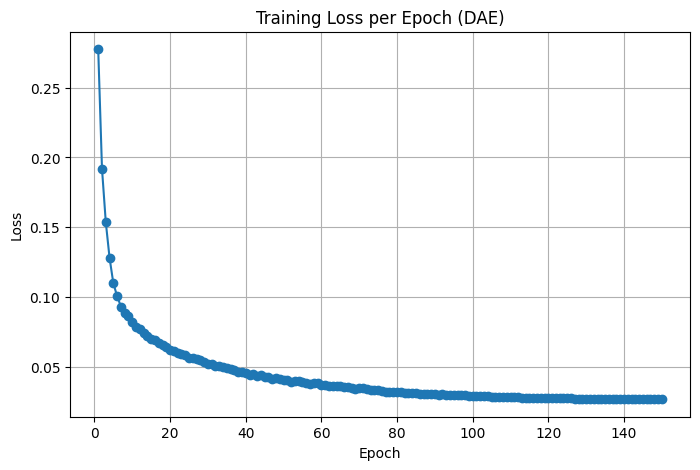

Evaluation started...
Evaluation PR AUC: 0.8064998091006401


In [7]:
 if __name__ == "__main__":
    args = get_args()
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)
    set_seed(2025)
    train_and_evaluate(args)

In [ ]:

import torch
import pandas as pd
import os
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import metrics

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 로드
model = DenoisingAutoencoder(input_channels=1, dropout=0.2).to(device)
model.load_state_dict(torch.load(os.path.join(args.model_dir, args.model_path), map_location=device))
model.eval()

# 데이터 로더 준비
eval_loader, file_list = get_eval_loader(args)
criterion = torch.nn.MSELoss()

# 결과 저장 리스트
results = []
y_true, y_pred = [], []

for idx, data in enumerate(eval_loader):
    spec, anomaly_label = data[0].to(device), data[1].item()

    with torch.no_grad():
        recon_spec = model(spec)
        loss = criterion(recon_spec, spec).item()

    # 파일 이름이 존재하는지 확인 후 저장
    file_name = file_list[idx] if idx < len(file_list) else f"unknown_{idx}"
    results.append([file_name, anomaly_label, loss])
    y_true.append(1 if anomaly_label > 0 else 0)
    y_pred.append(loss)

# CSV 저장
df_results = pd.DataFrame(results, columns=["File Name", "Anomaly Label", "Loss"])
csv_file_path = os.path.join(args.result_dir, "test_results_dae_10.csv")
df_results.to_csv(csv_file_path, index=False)
print(f"테스트가 완료되었습니다. 결과는 {csv_file_path}에 저장되었습니다.")

# AUC 평가
auc = metrics.roc_auc_score(y_true, y_pred)
print(f"Evaluation AUC: {auc:.4f}")

## 평가 데이터 바꿔서 모델 가중치 불러오기

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
import torchaudio

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 평가 데이터 경로 설정
eval_dir = "/content/ICSV31AIChallengeDataset/eval"

# 모델 생성 및 가중치 불러오기
dropout = 0.05  # args 없이 직접 설정
model = DAEModel(dropout=dropout).to(device)

checkpoint_path = "/content/drive/MyDrive/model_dae_b.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print("모델 가중치 로드 완료")

#######################
# 데이터 로드 함수 (디렉토리 문제 해결)
#######################
def get_eval_loader(eval_dir: str) -> tuple:
    """ 새로운 평가 데이터 로드 (오디오 파일만 포함) """
    file_list = sorted(os.listdir(eval_dir))

    # 오직 ".wav" 파일만 포함 (디렉토리 제외)
    file_list = [os.path.join(eval_dir, f) for f in file_list if f.endswith(".wav")]

    if not file_list:
        raise ValueError(f"{eval_dir}에 유효한 .wav 파일이 없습니다.")

    dataset = EvalDataset(file_list)
    return DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0), file_list

#######################
# Dataset 클래스 (STFT 변환 포함)
#######################
class EvalDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        wav_path = self.file_list[idx]
        spec = self.wav_to_log_stft(wav_path, sr=16000, n_fft=2048, win_length=512, hop_length=512, power=2.0)

        # 정답 라벨 추출 (파일명 기반)
        anomaly_label = 1 if "anomaly" in wav_path else 0

        return spec, anomaly_label

    @staticmethod
    def wav_to_log_stft(wav_path: str, sr: int, n_fft: int, win_length: int, hop_length: int, power: float) -> torch.Tensor:
        """ 오디오 파일을 로그 STFT 변환 """
        stft_transform = torchaudio.transforms.Spectrogram(
            n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=power
        )
        wav_data, _ = torchaudio.load(wav_path)
        spec = stft_transform(wav_data)
        amp_to_db = torchaudio.transforms.AmplitudeToDB()
        log_spec = amp_to_db(spec)
        log_spec = (log_spec - log_spec.mean()) / (log_spec.std() + 1e-9)  # 정규화
        return log_spec

#######################
# 평가 데이터 로드
#######################
eval_loader, file_list = get_eval_loader(eval_dir)

# 손실 함수 설정
criterion = nn.MSELoss()

# AUC 계산을 위한 리스트 초기화
y_true, y_pred = [], []

print("새로운 평가 데이터셋을 사용하여 AUC 계산 중...")
with torch.no_grad():
    for idx, data in enumerate(eval_loader):
        spec = data[0].to(device)  # 입력 데이터 (로그 STFT)
        anomaly_label = data[1]  # 정답 라벨 (정상=0, 이상=1)

        decoded = model(spec)
        loss = criterion(decoded, spec)  # MSE 기반 이상 탐지 점수

        # 수정된 부분: `.item()` 대신 `.tolist()` 사용
        y_true.extend(anomaly_label.view(-1).tolist())  # 개별적으로 저장
        y_pred.extend(loss.view(-1).tolist())  # 개별적으로 저장

# AUC 점수 계산
auc_score = roc_auc_score(y_true, y_pred)
print(f"새로운 평가 데이터 ({eval_dir})에서 AUC Score: {auc_score:.4f}")


RuntimeError: Error(s) in loading state_dict for DenoisingAutoencoder:
	Missing key(s) in state_dict: "enc1.resblock.conv1.weight", "enc1.resblock.conv1.bias", "enc1.resblock.bn1.weight", "enc1.resblock.bn1.bias", "enc1.resblock.bn1.running_mean", "enc1.resblock.bn1.running_var", "enc1.resblock.conv2.weight", "enc1.resblock.conv2.bias", "enc1.resblock.bn2.weight", "enc1.resblock.bn2.bias", "enc1.resblock.bn2.running_mean", "enc1.resblock.bn2.running_var", "enc1.resblock.downsample.0.weight", "enc1.resblock.downsample.0.bias", "enc1.resblock.downsample.1.weight", "enc1.resblock.downsample.1.bias", "enc1.resblock.downsample.1.running_mean", "enc1.resblock.downsample.1.running_var", "enc2.resblock.conv1.weight", "enc2.resblock.conv1.bias", "enc2.resblock.bn1.weight", "enc2.resblock.bn1.bias", "enc2.resblock.bn1.running_mean", "enc2.resblock.bn1.running_var", "enc2.resblock.conv2.weight", "enc2.resblock.conv2.bias", "enc2.resblock.bn2.weight", "enc2.resblock.bn2.bias", "enc2.resblock.bn2.running_mean", "enc2.resblock.bn2.running_var", "enc2.resblock.downsample.0.weight", "enc2.resblock.downsample.0.bias", "enc2.resblock.downsample.1.weight", "enc2.resblock.downsample.1.bias", "enc2.resblock.downsample.1.running_mean", "enc2.resblock.downsample.1.running_var", "enc3.resblock.conv1.weight", "enc3.resblock.conv1.bias", "enc3.resblock.bn1.weight", "enc3.resblock.bn1.bias", "enc3.resblock.bn1.running_mean", "enc3.resblock.bn1.running_var", "enc3.resblock.conv2.weight", "enc3.resblock.conv2.bias", "enc3.resblock.bn2.weight", "enc3.resblock.bn2.bias", "enc3.resblock.bn2.running_mean", "enc3.resblock.bn2.running_var", "enc3.resblock.downsample.0.weight", "enc3.resblock.downsample.0.bias", "enc3.resblock.downsample.1.weight", "enc3.resblock.downsample.1.bias", "enc3.resblock.downsample.1.running_mean", "enc3.resblock.downsample.1.running_var", "enc4.resblock.conv1.weight", "enc4.resblock.conv1.bias", "enc4.resblock.bn1.weight", "enc4.resblock.bn1.bias", "enc4.resblock.bn1.running_mean", "enc4.resblock.bn1.running_var", "enc4.resblock.conv2.weight", "enc4.resblock.conv2.bias", "enc4.resblock.bn2.weight", "enc4.resblock.bn2.bias", "enc4.resblock.bn2.running_mean", "enc4.resblock.bn2.running_var", "enc4.resblock.downsample.0.weight", "enc4.resblock.downsample.0.bias", "enc4.resblock.downsample.1.weight", "enc4.resblock.downsample.1.bias", "enc4.resblock.downsample.1.running_mean", "enc4.resblock.downsample.1.running_var", "enc5.resblock.conv1.weight", "enc5.resblock.conv1.bias", "enc5.resblock.bn1.weight", "enc5.resblock.bn1.bias", "enc5.resblock.bn1.running_mean", "enc5.resblock.bn1.running_var", "enc5.resblock.conv2.weight", "enc5.resblock.conv2.bias", "enc5.resblock.bn2.weight", "enc5.resblock.bn2.bias", "enc5.resblock.bn2.running_mean", "enc5.resblock.bn2.running_var", "enc5.resblock.downsample.0.weight", "enc5.resblock.downsample.0.bias", "enc5.resblock.downsample.1.weight", "enc5.resblock.downsample.1.bias", "enc5.resblock.downsample.1.running_mean", "enc5.resblock.downsample.1.running_var", "dec5.deconv.weight", "dec5.deconv.bias", "dec5.bn.weight", "dec5.bn.bias", "dec5.bn.running_mean", "dec5.bn.running_var", "dec5.resblock.conv1.weight", "dec5.resblock.conv1.bias", "dec5.resblock.bn1.weight", "dec5.resblock.bn1.bias", "dec5.resblock.bn1.running_mean", "dec5.resblock.bn1.running_var", "dec5.resblock.conv2.weight", "dec5.resblock.conv2.bias", "dec5.resblock.bn2.weight", "dec5.resblock.bn2.bias", "dec5.resblock.bn2.running_mean", "dec5.resblock.bn2.running_var", "dec5.resblock.downsample.0.weight", "dec5.resblock.downsample.0.bias", "dec5.resblock.downsample.1.weight", "dec5.resblock.downsample.1.bias", "dec5.resblock.downsample.1.running_mean", "dec5.resblock.downsample.1.running_var", "dec4.deconv.weight", "dec4.deconv.bias", "dec4.bn.weight", "dec4.bn.bias", "dec4.bn.running_mean", "dec4.bn.running_var", "dec4.resblock.conv1.weight", "dec4.resblock.conv1.bias", "dec4.resblock.bn1.weight", "dec4.resblock.bn1.bias", "dec4.resblock.bn1.running_mean", "dec4.resblock.bn1.running_var", "dec4.resblock.conv2.weight", "dec4.resblock.conv2.bias", "dec4.resblock.bn2.weight", "dec4.resblock.bn2.bias", "dec4.resblock.bn2.running_mean", "dec4.resblock.bn2.running_var", "dec4.resblock.downsample.0.weight", "dec4.resblock.downsample.0.bias", "dec4.resblock.downsample.1.weight", "dec4.resblock.downsample.1.bias", "dec4.resblock.downsample.1.running_mean", "dec4.resblock.downsample.1.running_var", "dec3.deconv.weight", "dec3.deconv.bias", "dec3.bn.weight", "dec3.bn.bias", "dec3.bn.running_mean", "dec3.bn.running_var", "dec3.resblock.conv1.weight", "dec3.resblock.conv1.bias", "dec3.resblock.bn1.weight", "dec3.resblock.bn1.bias", "dec3.resblock.bn1.running_mean", "dec3.resblock.bn1.running_var", "dec3.resblock.conv2.weight", "dec3.resblock.conv2.bias", "dec3.resblock.bn2.weight", "dec3.resblock.bn2.bias", "dec3.resblock.bn2.running_mean", "dec3.resblock.bn2.running_var", "dec3.resblock.downsample.0.weight", "dec3.resblock.downsample.0.bias", "dec3.resblock.downsample.1.weight", "dec3.resblock.downsample.1.bias", "dec3.resblock.downsample.1.running_mean", "dec3.resblock.downsample.1.running_var", "dec2.deconv.weight", "dec2.deconv.bias", "dec2.bn.weight", "dec2.bn.bias", "dec2.bn.running_mean", "dec2.bn.running_var", "dec2.resblock.conv1.weight", "dec2.resblock.conv1.bias", "dec2.resblock.bn1.weight", "dec2.resblock.bn1.bias", "dec2.resblock.bn1.running_mean", "dec2.resblock.bn1.running_var", "dec2.resblock.conv2.weight", "dec2.resblock.conv2.bias", "dec2.resblock.bn2.weight", "dec2.resblock.bn2.bias", "dec2.resblock.bn2.running_mean", "dec2.resblock.bn2.running_var", "dec2.resblock.downsample.0.weight", "dec2.resblock.downsample.0.bias", "dec2.resblock.downsample.1.weight", "dec2.resblock.downsample.1.bias", "dec2.resblock.downsample.1.running_mean", "dec2.resblock.downsample.1.running_var", "dec1.weight", "dec1.bias". 
	Unexpected key(s) in state_dict: "_orig_mod.enc1.resblock.conv1.weight", "_orig_mod.enc1.resblock.conv1.bias", "_orig_mod.enc1.resblock.bn1.weight", "_orig_mod.enc1.resblock.bn1.bias", "_orig_mod.enc1.resblock.bn1.running_mean", "_orig_mod.enc1.resblock.bn1.running_var", "_orig_mod.enc1.resblock.bn1.num_batches_tracked", "_orig_mod.enc1.resblock.conv2.weight", "_orig_mod.enc1.resblock.conv2.bias", "_orig_mod.enc1.resblock.bn2.weight", "_orig_mod.enc1.resblock.bn2.bias", "_orig_mod.enc1.resblock.bn2.running_mean", "_orig_mod.enc1.resblock.bn2.running_var", "_orig_mod.enc1.resblock.bn2.num_batches_tracked", "_orig_mod.enc1.resblock.downsample.0.weight", "_orig_mod.enc1.resblock.downsample.0.bias", "_orig_mod.enc1.resblock.downsample.1.weight", "_orig_mod.enc1.resblock.downsample.1.bias", "_orig_mod.enc1.resblock.downsample.1.running_mean", "_orig_mod.enc1.resblock.downsample.1.running_var", "_orig_mod.enc1.resblock.downsample.1.num_batches_tracked", "_orig_mod.enc2.resblock.conv1.weight", "_orig_mod.enc2.resblock.conv1.bias", "_orig_mod.enc2.resblock.bn1.weight", "_orig_mod.enc2.resblock.bn1.bias", "_orig_mod.enc2.resblock.bn1.running_mean", "_orig_mod.enc2.resblock.bn1.running_var", "_orig_mod.enc2.resblock.bn1.num_batches_tracked", "_orig_mod.enc2.resblock.conv2.weight", "_orig_mod.enc2.resblock.conv2.bias", "_orig_mod.enc2.resblock.bn2.weight", "_orig_mod.enc2.resblock.bn2.bias", "_orig_mod.enc2.resblock.bn2.running_mean", "_orig_mod.enc2.resblock.bn2.running_var", "_orig_mod.enc2.resblock.bn2.num_batches_tracked", "_orig_mod.enc2.resblock.downsample.0.weight", "_orig_mod.enc2.resblock.downsample.0.bias", "_orig_mod.enc2.resblock.downsample.1.weight", "_orig_mod.enc2.resblock.downsample.1.bias", "_orig_mod.enc2.resblock.downsample.1.running_mean", "_orig_mod.enc2.resblock.downsample.1.running_var", "_orig_mod.enc2.resblock.downsample.1.num_batches_tracked", "_orig_mod.enc3.resblock.conv1.weight", "_orig_mod.enc3.resblock.conv1.bias", "_orig_mod.enc3.resblock.bn1.weight", "_orig_mod.enc3.resblock.bn1.bias", "_orig_mod.enc3.resblock.bn1.running_mean", "_orig_mod.enc3.resblock.bn1.running_var", "_orig_mod.enc3.resblock.bn1.num_batches_tracked", "_orig_mod.enc3.resblock.conv2.weight", "_orig_mod.enc3.resblock.conv2.bias", "_orig_mod.enc3.resblock.bn2.weight", "_orig_mod.enc3.resblock.bn2.bias", "_orig_mod.enc3.resblock.bn2.running_mean", "_orig_mod.enc3.resblock.bn2.running_var", "_orig_mod.enc3.resblock.bn2.num_batches_tracked", "_orig_mod.enc3.resblock.downsample.0.weight", "_orig_mod.enc3.resblock.downsample.0.bias", "_orig_mod.enc3.resblock.downsample.1.weight", "_orig_mod.enc3.resblock.downsample.1.bias", "_orig_mod.enc3.resblock.downsample.1.running_mean", "_orig_mod.enc3.resblock.downsample.1.running_var", "_orig_mod.enc3.resblock.downsample.1.num_batches_tracked", "_orig_mod.enc4.resblock.conv1.weight", "_orig_mod.enc4.resblock.conv1.bias", "_orig_mod.enc4.resblock.bn1.weight", "_orig_mod.enc4.resblock.bn1.bias", "_orig_mod.enc4.resblock.bn1.running_mean", "_orig_mod.enc4.resblock.bn1.running_var", "_orig_mod.enc4.resblock.bn1.num_batches_tracked", "_orig_mod.enc4.resblock.conv2.weight", "_orig_mod.enc4.resblock.conv2.bias", "_orig_mod.enc4.resblock.bn2.weight", "_orig_mod.enc4.resblock.bn2.bias", "_orig_mod.enc4.resblock.bn2.running_mean", "_orig_mod.enc4.resblock.bn2.running_var", "_orig_mod.enc4.resblock.bn2.num_batches_tracked", "_orig_mod.enc4.resblock.downsample.0.weight", "_orig_mod.enc4.resblock.downsample.0.bias", "_orig_mod.enc4.resblock.downsample.1.weight", "_orig_mod.enc4.resblock.downsample.1.bias", "_orig_mod.enc4.resblock.downsample.1.running_mean", "_orig_mod.enc4.resblock.downsample.1.running_var", "_orig_mod.enc4.resblock.downsample.1.num_batches_tracked", "_orig_mod.enc5.resblock.conv1.weight", "_orig_mod.enc5.resblock.conv1.bias", "_orig_mod.enc5.resblock.bn1.weight", "_orig_mod.enc5.resblock.bn1.bias", "_orig_mod.enc5.resblock.bn1.running_mean", "_orig_mod.enc5.resblock.bn1.running_var", "_orig_mod.enc5.resblock.bn1.num_batches_tracked", "_orig_mod.enc5.resblock.conv2.weight", "_orig_mod.enc5.resblock.conv2.bias", "_orig_mod.enc5.resblock.bn2.weight", "_orig_mod.enc5.resblock.bn2.bias", "_orig_mod.enc5.resblock.bn2.running_mean", "_orig_mod.enc5.resblock.bn2.running_var", "_orig_mod.enc5.resblock.bn2.num_batches_tracked", "_orig_mod.enc5.resblock.downsample.0.weight", "_orig_mod.enc5.resblock.downsample.0.bias", "_orig_mod.enc5.resblock.downsample.1.weight", "_orig_mod.enc5.resblock.downsample.1.bias", "_orig_mod.enc5.resblock.downsample.1.running_mean", "_orig_mod.enc5.resblock.downsample.1.running_var", "_orig_mod.enc5.resblock.downsample.1.num_batches_tracked", "_orig_mod.dec5.deconv.weight", "_orig_mod.dec5.deconv.bias", "_orig_mod.dec5.bn.weight", "_orig_mod.dec5.bn.bias", "_orig_mod.dec5.bn.running_mean", "_orig_mod.dec5.bn.running_var", "_orig_mod.dec5.bn.num_batches_tracked", "_orig_mod.dec5.resblock.conv1.weight", "_orig_mod.dec5.resblock.conv1.bias", "_orig_mod.dec5.resblock.bn1.weight", "_orig_mod.dec5.resblock.bn1.bias", "_orig_mod.dec5.resblock.bn1.running_mean", "_orig_mod.dec5.resblock.bn1.running_var", "_orig_mod.dec5.resblock.bn1.num_batches_tracked", "_orig_mod.dec5.resblock.conv2.weight", "_orig_mod.dec5.resblock.conv2.bias", "_orig_mod.dec5.resblock.bn2.weight", "_orig_mod.dec5.resblock.bn2.bias", "_orig_mod.dec5.resblock.bn2.running_mean", "_orig_mod.dec5.resblock.bn2.running_var", "_orig_mod.dec5.resblock.bn2.num_batches_tracked", "_orig_mod.dec5.resblock.downsample.0.weight", "_orig_mod.dec5.resblock.downsample.0.bias", "_orig_mod.dec5.resblock.downsample.1.weight", "_orig_mod.dec5.resblock.downsample.1.bias", "_orig_mod.dec5.resblock.downsample.1.running_mean", "_orig_mod.dec5.resblock.downsample.1.running_var", "_orig_mod.dec5.resblock.downsample.1.num_batches_tracked", "_orig_mod.dec4.deconv.weight", "_orig_mod.dec4.deconv.bias", "_orig_mod.dec4.bn.weight", "_orig_mod.dec4.bn.bias", "_orig_mod.dec4.bn.running_mean", "_orig_mod.dec4.bn.running_var", "_orig_mod.dec4.bn.num_batches_tracked", "_orig_mod.dec4.resblock.conv1.weight", "_orig_mod.dec4.resblock.conv1.bias", "_orig_mod.dec4.resblock.bn1.weight", "_orig_mod.dec4.resblock.bn1.bias", "_orig_mod.dec4.resblock.bn1.running_mean", "_orig_mod.dec4.resblock.bn1.running_var", "_orig_mod.dec4.resblock.bn1.num_batches_tracked", "_orig_mod.dec4.resblock.conv2.weight", "_orig_mod.dec4.resblock.conv2.bias", "_orig_mod.dec4.resblock.bn2.weight", "_orig_mod.dec4.resblock.bn2.bias", "_orig_mod.dec4.resblock.bn2.running_mean", "_orig_mod.dec4.resblock.bn2.running_var", "_orig_mod.dec4.resblock.bn2.num_batches_tracked", "_orig_mod.dec4.resblock.downsample.0.weight", "_orig_mod.dec4.resblock.downsample.0.bias", "_orig_mod.dec4.resblock.downsample.1.weight", "_orig_mod.dec4.resblock.downsample.1.bias", "_orig_mod.dec4.resblock.downsample.1.running_mean", "_orig_mod.dec4.resblock.downsample.1.running_var", "_orig_mod.dec4.resblock.downsample.1.num_batches_tracked", "_orig_mod.dec3.deconv.weight", "_orig_mod.dec3.deconv.bias", "_orig_mod.dec3.bn.weight", "_orig_mod.dec3.bn.bias", "_orig_mod.dec3.bn.running_mean", "_orig_mod.dec3.bn.running_var", "_orig_mod.dec3.bn.num_batches_tracked", "_orig_mod.dec3.resblock.conv1.weight", "_orig_mod.dec3.resblock.conv1.bias", "_orig_mod.dec3.resblock.bn1.weight", "_orig_mod.dec3.resblock.bn1.bias", "_orig_mod.dec3.resblock.bn1.running_mean", "_orig_mod.dec3.resblock.bn1.running_var", "_orig_mod.dec3.resblock.bn1.num_batches_tracked", "_orig_mod.dec3.resblock.conv2.weight", "_orig_mod.dec3.resblock.conv2.bias", "_orig_mod.dec3.resblock.bn2.weight", "_orig_mod.dec3.resblock.bn2.bias", "_orig_mod.dec3.resblock.bn2.running_mean", "_orig_mod.dec3.resblock.bn2.running_var", "_orig_mod.dec3.resblock.bn2.num_batches_tracked", "_orig_mod.dec3.resblock.downsample.0.weight", "_orig_mod.dec3.resblock.downsample.0.bias", "_orig_mod.dec3.resblock.downsample.1.weight", "_orig_mod.dec3.resblock.downsample.1.bias", "_orig_mod.dec3.resblock.downsample.1.running_mean", "_orig_mod.dec3.resblock.downsample.1.running_var", "_orig_mod.dec3.resblock.downsample.1.num_batches_tracked", "_orig_mod.dec2.deconv.weight", "_orig_mod.dec2.deconv.bias", "_orig_mod.dec2.bn.weight", "_orig_mod.dec2.bn.bias", "_orig_mod.dec2.bn.running_mean", "_orig_mod.dec2.bn.running_var", "_orig_mod.dec2.bn.num_batches_tracked", "_orig_mod.dec2.resblock.conv1.weight", "_orig_mod.dec2.resblock.conv1.bias", "_orig_mod.dec2.resblock.bn1.weight", "_orig_mod.dec2.resblock.bn1.bias", "_orig_mod.dec2.resblock.bn1.running_mean", "_orig_mod.dec2.resblock.bn1.running_var", "_orig_mod.dec2.resblock.bn1.num_batches_tracked", "_orig_mod.dec2.resblock.conv2.weight", "_orig_mod.dec2.resblock.conv2.bias", "_orig_mod.dec2.resblock.bn2.weight", "_orig_mod.dec2.resblock.bn2.bias", "_orig_mod.dec2.resblock.bn2.running_mean", "_orig_mod.dec2.resblock.bn2.running_var", "_orig_mod.dec2.resblock.bn2.num_batches_tracked", "_orig_mod.dec2.resblock.downsample.0.weight", "_orig_mod.dec2.resblock.downsample.0.bias", "_orig_mod.dec2.resblock.downsample.1.weight", "_orig_mod.dec2.resblock.downsample.1.bias", "_orig_mod.dec2.resblock.downsample.1.running_mean", "_orig_mod.dec2.resblock.downsample.1.running_var", "_orig_mod.dec2.resblock.downsample.1.num_batches_tracked", "_orig_mod.dec1.weight", "_orig_mod.dec1.bias". 

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, confusion_matrix, roc_curve
import torchaudio
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 평가 데이터 경로 설정
eval_dir = "/content/ICSV31AIChallengeDataset/eval"

# 모델 생성 및 가중치 불러오기
dropout = 0.05  # args 없이 직접 설정
model = DAEModel(dropout=dropout).to(device)

checkpoint_path = "/content/drive/MyDrive/model_dae_b0319.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device), strict=False)
model.eval()
print("모델 가중치 로드 완료")

#######################
# 데이터 로드 함수
#######################
def get_eval_loader(eval_dir: str) -> tuple:
    """ 평가 데이터 로드 (오디오 파일만 포함) """
    file_list = sorted(os.listdir(eval_dir))
    file_list = [os.path.join(eval_dir, f) for f in file_list if f.endswith(".wav")]

    if not file_list:
        raise ValueError(f"{eval_dir}에 유효한 .wav 파일이 없습니다.")

    dataset = EvalDataset(file_list)
    return DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0), file_list

#######################
# Dataset 클래스 (STFT 변환 포함)
#######################
class EvalDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        wav_path = self.file_list[idx]
        spec = self.wav_to_log_stft(wav_path, sr=16000, n_fft=2048, win_length=512, hop_length=256, power=2.0)

        # 정답 라벨 추출 (파일명 기반)
        anomaly_label = 1 if "anomaly" in wav_path else 0

        return spec, anomaly_label

    @staticmethod
    def wav_to_log_stft(wav_path: str, sr: int, n_fft: int, win_length: int, hop_length: int, power: float) -> torch.Tensor:
        """ 오디오 파일을 로그 STFT 변환 """
        stft_transform = torchaudio.transforms.Spectrogram(
            n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=power
        )
        wav_data, _ = torchaudio.load(wav_path)
        spec = stft_transform(wav_data)
        amp_to_db = torchaudio.transforms.AmplitudeToDB()
        log_spec = amp_to_db(spec)
        log_spec = (log_spec - log_spec.mean()) / (log_spec.std() + 1e-9)  # 정규화
        return log_spec

#######################
# 평가 데이터 로드
#######################
eval_loader, file_list = get_eval_loader(eval_dir)

# 손실 함수 설정
criterion = nn.MSELoss()

# AUC 계산을 위한 리스트 초기화
y_true, y_pred = [], []

print("새로운 평가 데이터셋을 사용하여 AUC 계산 중...")
with torch.no_grad():
    for idx, data in enumerate(eval_loader):
        spec = data[0].to(device)  # 입력 데이터 (로그 STFT)
        anomaly_label = data[1]  # 정답 라벨 (정상=0, 이상=1)

        decoded = model(spec)
        loss = criterion(decoded, spec)  # MSE 기반 이상 탐지 점수

        y_true.append(anomaly_label.item())  # 정상: 0, 이상: 1
        y_pred.append(loss.item())

#######################
# 평가 지표 계산
#######################
eval_loader, file_list = get_eval_loader(eval_dir)

# 손실 함수 설정
criterion = nn.MSELoss()

# AUC 계산을 위한 리스트 초기화
y_true, y_pred = [], []

print("새로운 평가 데이터셋을 사용하여 AUC 계산 중...")
with torch.no_grad():
    for idx, data in enumerate(eval_loader):
        spec = data[0].to(device)  # 입력 데이터 (로그 STFT)
        anomaly_label = data[1]  # 정답 라벨 (정상=0, 이상=1)

        decoded = model(spec)
        loss = criterion(decoded, spec)  # MSE 기반 이상 탐지 점수

        y_true.append(anomaly_label.item())  # 정상: 0, 이상: 1
        y_pred.append(loss.item())

# AUC 점수 계산
auc_score = roc_auc_score(y_true, y_pred)
print(f"평가 데이터 ({eval_dir})에서 AUC Score: {auc_score:.4f}")


모델 가중치 로드 완료
새로운 평가 데이터셋을 사용하여 AUC 계산 중...
새로운 평가 데이터셋을 사용하여 AUC 계산 중...
평가 데이터 (/content/ICSV31AIChallengeDataset/eval)에서 AUC Score: 0.4974
